<a href="https://colab.research.google.com/github/Wayne122/CMPE257/blob/main/Week2_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE 257 Week 2 Homework

Author: Han-Wei Lin

Dataset source: https://code.datasciencedojo.com/tshrivas/dojoHub/tree/c59bed891626783e706db0982b8f5148fd177824/Wholesale%20Customers

Dataset in-drive ID: 1oVh_Y7qERMetEydoBQq68_df9KKhcRk-

Data:
The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories.

Goal:
To find the general types of customers. We may find a cluster indicating types of customers tend to buy something more or tends to buy something along another item(s).

##Import library and data

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1oVh_Y7qERMetEydoBQq68_df9KKhcRk-"})
downloaded.GetContentFile('dataset.csv')

data = pd.read_csv('dataset.csv')
data.drop(['Channel', 'Region'], axis=1, inplace=True)
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


##Visualize data

###1. Heatmap

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


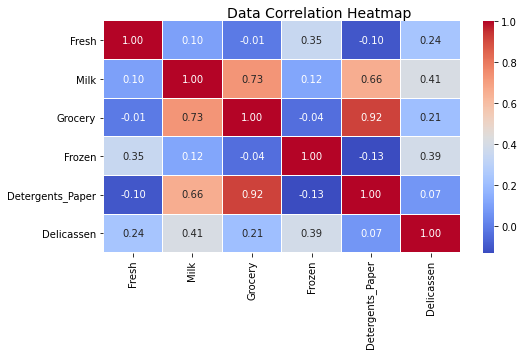

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8, 4))
corr = data.corr()
hm = sns.heatmap(round(corr, 2), annot=True, ax=ax, cmap="coolwarm", fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Data Correlation Heatmap', fontsize=14)

###2. Pair-wise scatter plots

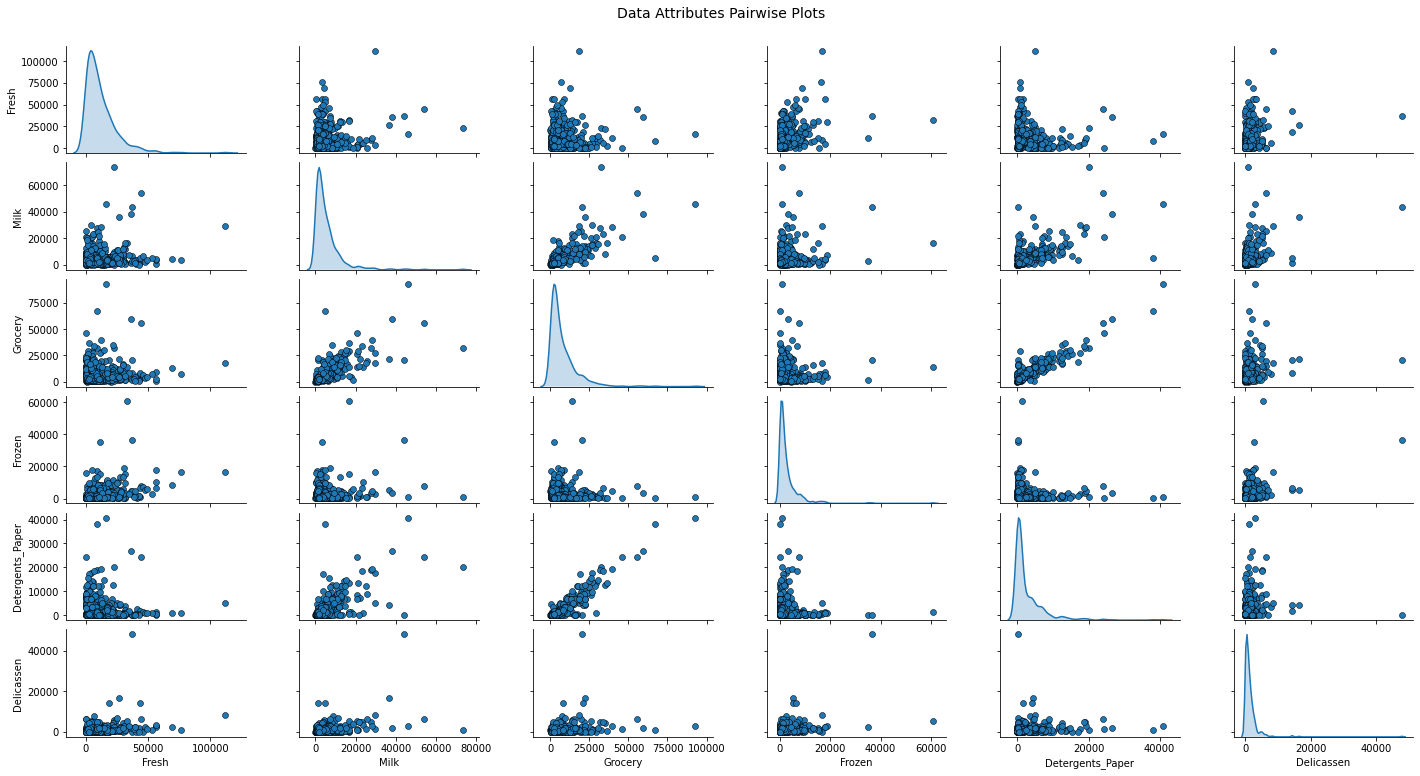

In [ ]:
pp = sns.pairplot(data, height=1.8, aspect=1.8, plot_kws=dict(edgecolor="k", linewidth=0.5), diag_kind="kde", diag_kws=dict(shade=True))
fig = pp.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Data Attributes Pairwise Plots', fontsize=14)

##GMM

###Import necessary packages

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import itertools

###Find best k value

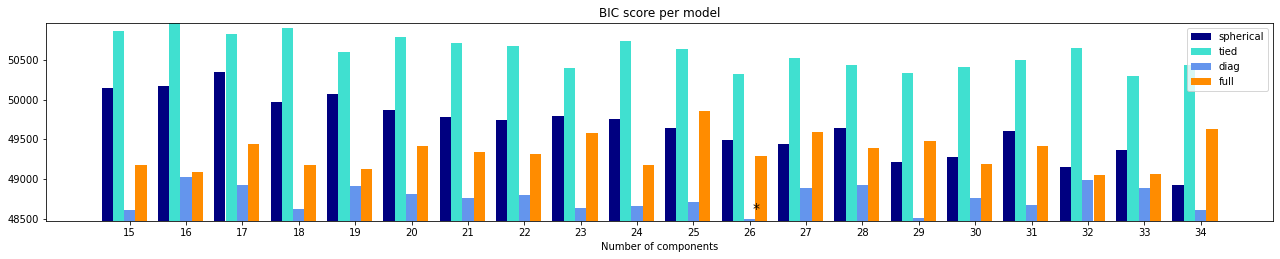

In [ ]:
lowest_bic = np.inf
bic = []
K = range(15, 35)
cv_types = ['spherical', 'tied', 'diag', 'full']


for cv_type in cv_types:
  for k in K:
    gmm = GaussianMixture(n_components=k, covariance_type=cv_type)
    gmm.fit(data)
    bic.append(gmm.bic(data))
    if bic[-1] < lowest_bic:
      lowest_bic = bic[-1]
      best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(22, 8))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(K) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(K):
                                  (i + 1) * len(K)],
                        width=.2, color=color))
plt.xticks(K)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(K)) + 14 + .65 +\
    .2 * np.floor(bic.argmin() / len(K))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

Best combo: k = 26, cv_type = 'diag'

###Combine cluster information to data

In [ ]:
labeled_data = pd.DataFrame(data=clf.predict(data), columns=['Cluster'])
labeled_data = pd.concat([data, labeled_data], axis=1)
labeled_data

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,12669,9656,7561,214,2674,1338,8
1,7057,9810,9568,1762,3293,1776,8
2,6353,8808,7684,2405,3516,7844,1
3,13265,1196,4221,6404,507,1788,18
4,22615,5410,7198,3915,1777,5185,23
...,...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204,14
436,39228,1431,764,4510,93,2346,9
437,14531,15488,30243,437,14841,1867,20
438,10290,1981,2232,1038,168,2125,9


###Visualize data (ignore outliers)

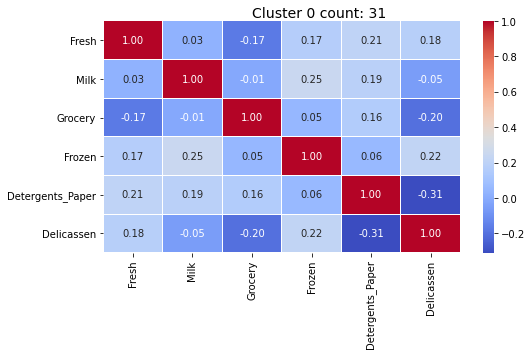

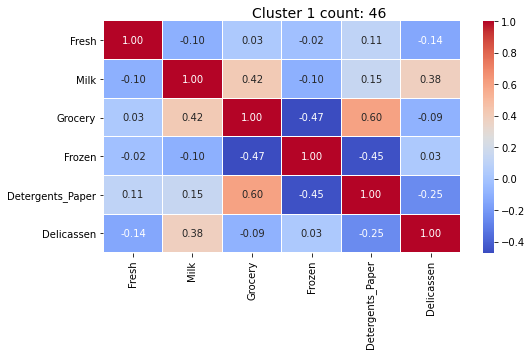

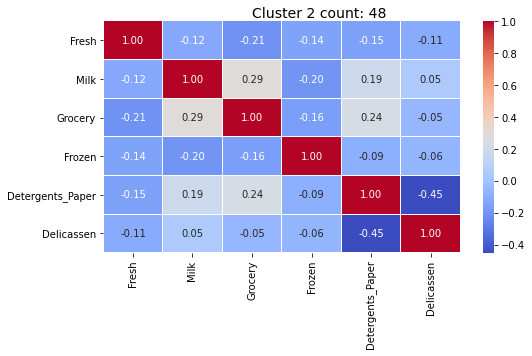

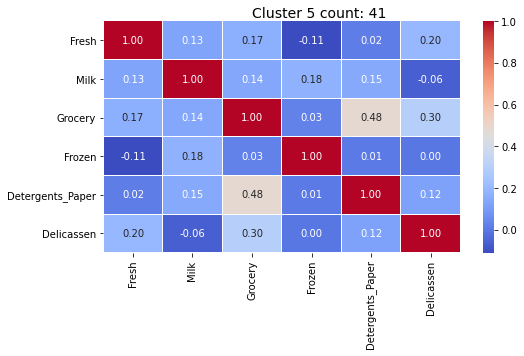

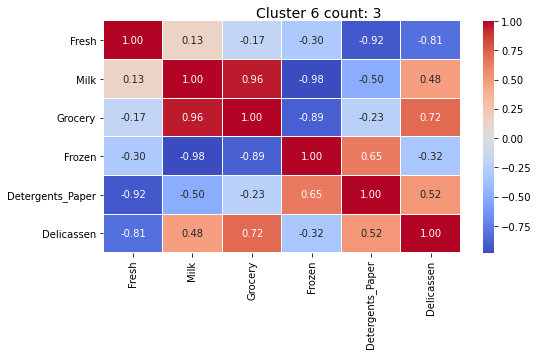

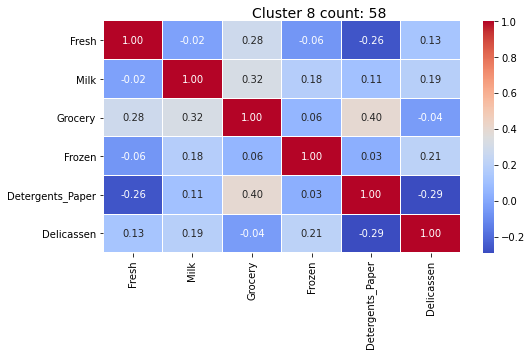

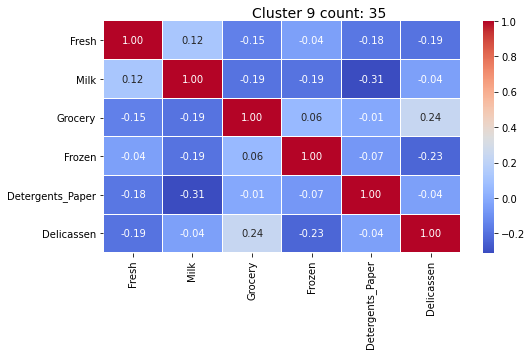

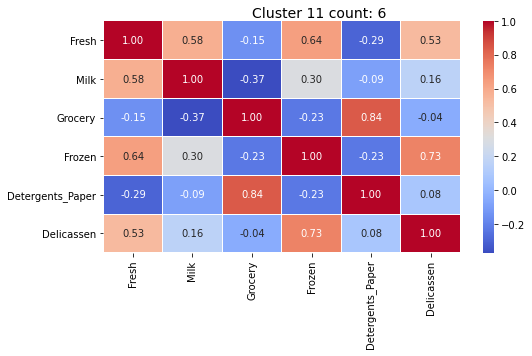

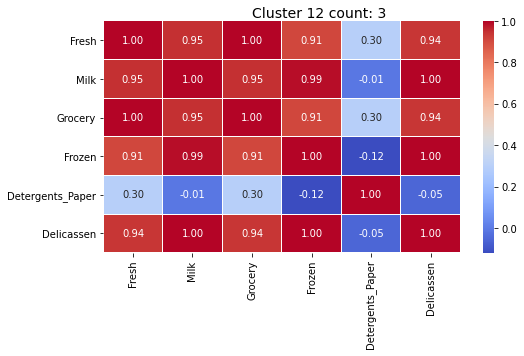

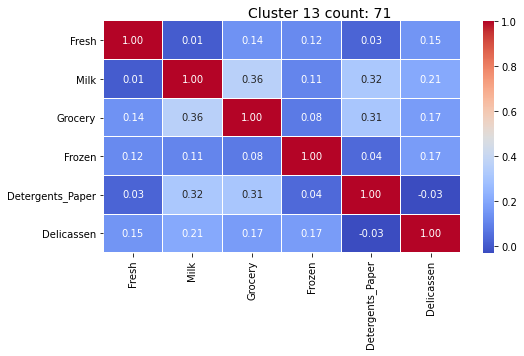

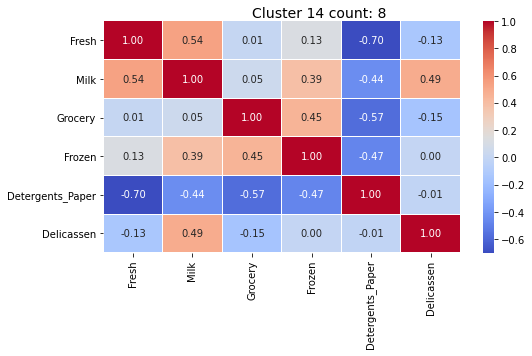

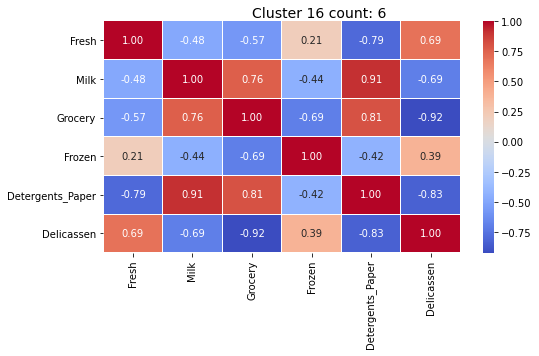

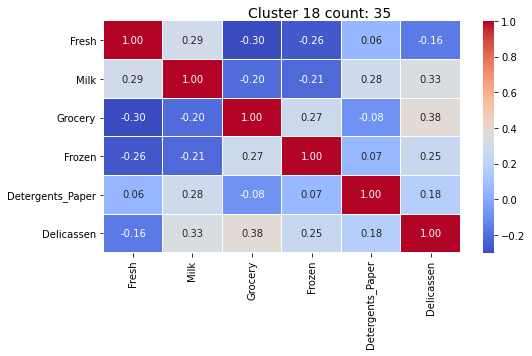

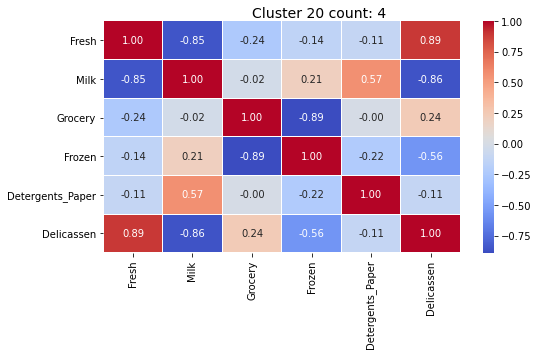

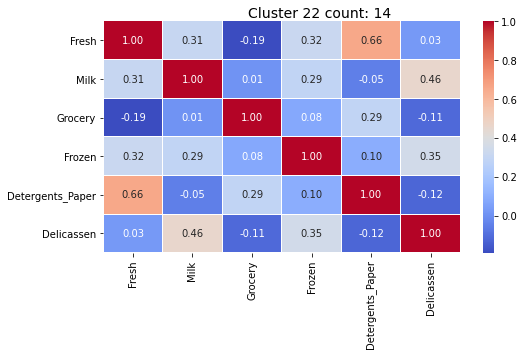

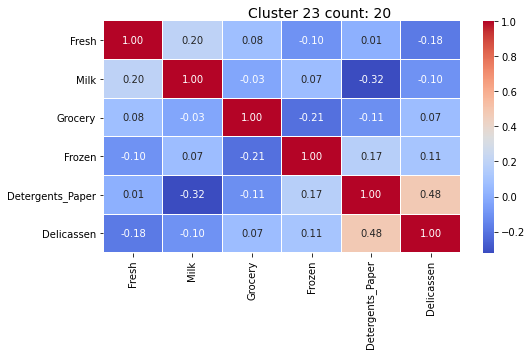

In [ ]:
l = list(clf.predict(data))
k = clf.get_params()['n_components']

for i in range(0, k):
  c = l.count(i)
  if c > 2:
    f, ax = plt.subplots(figsize=(8, 4))
    corr = data[labeled_data['Cluster']==i].corr()
    hm = sns.heatmap(round(corr, 2), annot=True, ax=ax, cmap="coolwarm", fmt='.2f', linewidths=.05)
    f.subplots_adjust(top=0.93)
    t= f.suptitle('Cluster ' + str(i) + ' count: ' + str(c), fontsize=14)

###Output file and inspect

In [ ]:
from google.colab import files
labeled_data.sort_values(by=['Cluster'], inplace=True)
labeled_data.to_csv("labeled_data_gmm.csv")
files.download("labeled_data_gmm.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Conclusion

It seems like using normalization before fitting the data into GMM will screw the result, so there is no scaling method in this practice.

To find the best k value for GMM, I used the BIC score to find it. However, it is hard to tell which is the better one with a lower scale. So I set the range higher than when I did with k-means. I think it is the same as if I apply mini-batch k-means for previous practice.

Since I set the k value way higher than previous practice, many clusters have only 1 or 2 records. I view them as outliers for this data.

To compare the two practices, I changed the k value in the first practice to 26 and inspected the result.

I guess it is because some of the data is in the overlap zone of multiple clusters, making some of the records be in the different clusters comparing both practices. Nevertheless, we can still find the same result of outliers being alone in a cluster group.

##References

https://colab.research.google.com/drive/1FJPQ5ZDZHWxAFHSpddUnk-EVXFIq86qh

https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.predict